# Exercise 0

This is a simple example on how to use Mad-X in Python to match a 10 m long FODO lattice. Each quadrupole is 1.5 m long.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xobjects as xo

In [5]:

env = xt.Environment()

#%%
env.vars({ 'kf': 0.2985, 
            'kd': -0.2985,
            'lquad': 0.5, 
            'ldrift': 4.5})

env.new('mq', xt.Quadrupole, length=env["lquad"])
env.new('mq.f', 'mq', k1='kf')
env.new('mq.d', 'mq', k1='kd')

#%%
fodo = env.new_line(components = [
                    env.place('mq.f', at=4.5 + env["lquad"]/2),
                    env.place('mq.d', at=9.5 + env["lquad"]/2),               
                    ]
                    )
fodo.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Drift,drift_1,True,False,None,False,Drift(length=4.5)
1,4.5,Quadrupole,mq.f,True,False,None,False,"Quadrupole(k1=0.298, k1s=0, length=0.5, num_mu..."
2,5.0,Drift,drift_2,True,False,None,False,Drift(length=4.5)
3,9.5,Quadrupole,mq.d,True,False,None,False,"Quadrupole(k1=-0.298, k1s=0, length=0.5, num_m..."
4,10.0,,_end_point,False,False,None,False,None


Table: 5 rows, 3 cols
name             value expr
t_turn_s             0 None
kf              0.2985 None
kd             -0.2985 None
lquad              0.5 None
ldrift             4.5 None

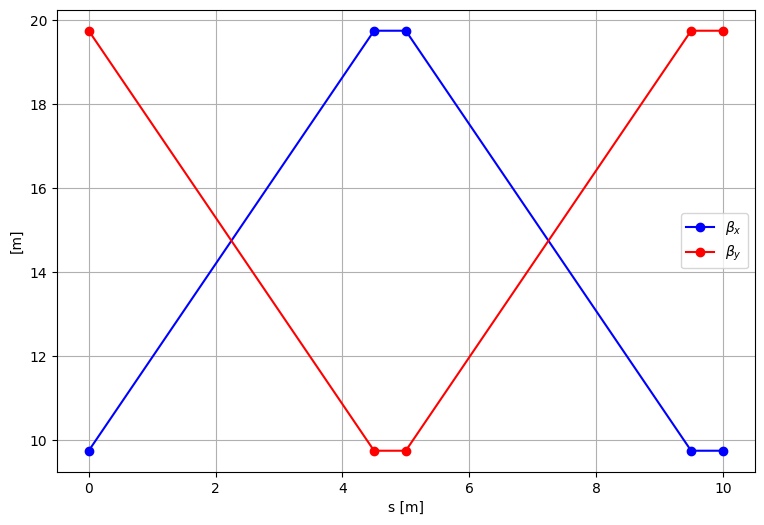

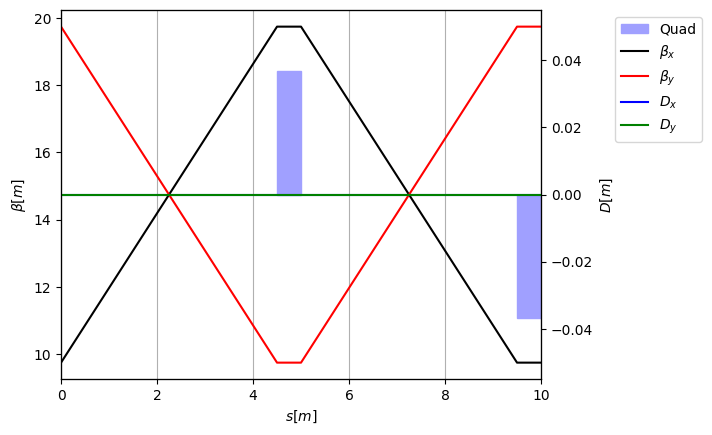

In [6]:
fodo.particle_ref = xt.Particles(p0c=6500e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)
# %%
context = xo.ContextCpu()
fodo.build_tracker(_context=context)
# %%
tw = fodo.twiss(method='4d')
# %%
fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(tw.s, tw.betx, 'o-', label=r"$\beta_x$", c="b", )
plt.plot(tw.s, tw.bety, 'o-',label=r"$\beta_y$", c="r")
plt.grid()
plt.ylabel("[m]")
plt.xlabel("s [m]")
plt.legend()

#%%
fodo.twiss4d().plot()

#%%
fodo.vars.get_table()

In [7]:

#%%

opt = fodo.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kf', 'kd'], step=1e-5),
    targets=xt.TargetSet(
        qx=0.25,
        qy=0.25,
    ))

print('Before match:')
opt.target_status()

opt.solve()

print('After match:')
opt.target_status()

print('\nMatch history')
opt.log()

Before match:el call n. 0               
Target status:                          
id state tag tol_met       residue   current_val    target_val description                         
0  ON          False     -0.132619      0.117381          0.25 'qx', val=0.25, tol=1e-09, weight=10
1  ON          False     -0.132619      0.117381          0.25 'qy', val=0.25, tol=1e-09, weight=10
Matching: model call n. 17               

After match:
Target status:                           
id state tag tol_met       residue   current_val    target_val description                         
0  ON           True   3.25961e-13          0.25          0.25 'qx', val=0.25, tol=1e-09, weight=10
1  ON           True    8.2323e-13          0.25          0.25 'qy', val=0.25, tol=1e-09, weight=10

Match history


Table: 5 rows, 14 cols
iteration                   penalty alpha tag tol_met target_active hit_limits vary_active ...
0                           1.87551    -1     nn      yy            nn         yy         
1                          0.275554     0     nn      yy            nn         yy         
2                        0.00877331     0     nn      yy            nn         yy         
3                        8.5548e-06     0     nn      yy            nn         yy         
4                       8.85415e-12     0     yy      yy            nn         yy         

{'kf': 0.2985, 'kd': -0.2985}
{'kf': 0.5856044576934822, 'kd': -0.5856044576941177}


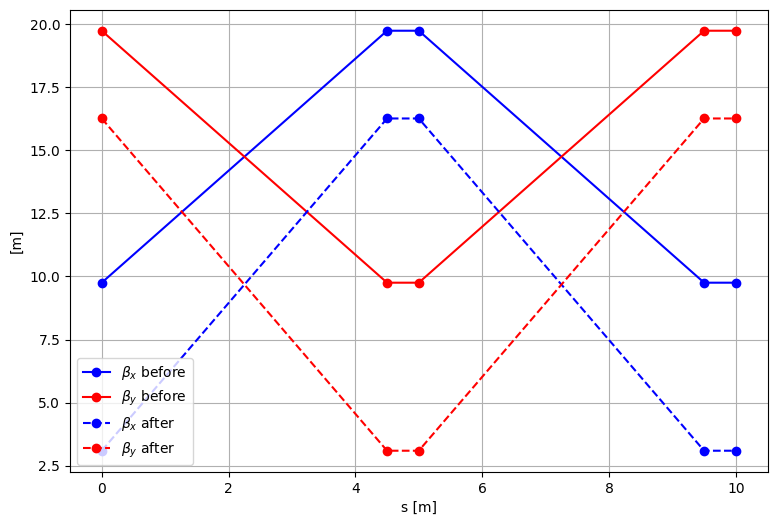

In [8]:

# %%
knobs_after_match = opt.get_knob_values()
knobs_before_match = opt.get_knob_values(iteration=0)
print(knobs_before_match)
print(knobs_after_match)
# %%
tw_after_matching = fodo.twiss(method='4d')
# %%
fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(tw.s, tw.betx, 'o-', label=r"$\beta_x$ before", c="b", )
plt.plot(tw.s, tw.bety, 'o-',label=r"$\beta_y$ before", c="r")

plt.plot(tw_after_matching.s, tw_after_matching.betx, 'o--', label=r"$\beta_x$ after", c="b", )
plt.plot(tw_after_matching.s, tw_after_matching.bety, 'o--',label=r"$\beta_y$ after", c="r")
plt.grid()
plt.ylabel("[m]")
plt.xlabel("s [m]")
plt.legend()

Matching: model call n. 16               

Matching: model call n. 12               

Matching: model call n. 12               

Matching: model call n. 12               

Matching: model call n. 12               

Matching: model call n. 12               

Matching: model call n. 12               

Matching: model call n. 12               

Matching: model call n. 12               

Matching: model call n. 12               

Matching: model call n. 12               

Matching: model call n. 16               

Matching: model call n. 16               

Matching: model call n. 16               



/var/folders/gj/9f2g0rd15hx1l3bhlzwcxj780000gn/T/ipykernel_4624/1772349492.py:23: RuntimeWarning: invalid value encountered in arcsin
  analytical = np.arcsin(10/(4*f))/np.pi


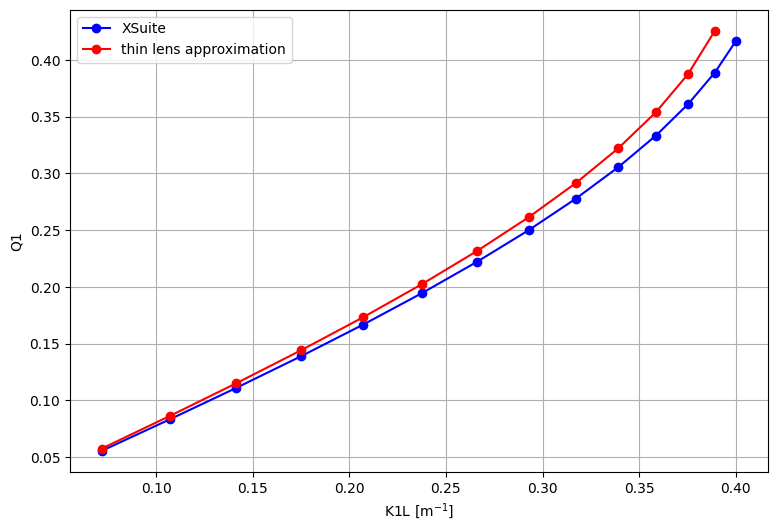

In [9]:




# %%
tunes_deg = np.arange(20, 160, 10)
tunes = tunes_deg/360

results_kf = []
results_kd = []
for current_tune in tunes:
    opt = fodo.match(
    solve=True,
    method='4d',
    vary=xt.VaryList(['kf', 'kd'], step=1e-5),
    targets=xt.TargetSet(
        qx=current_tune,
        qy=current_tune,
    ))
    knobs_after_match = opt.get_knob_values()
    results_kf.append(knobs_after_match['kf'])
    results_kd.append(knobs_after_match['kd'])
    
    
# %%
f = 1.0/np.array(results_kf)/fodo['mq.f'].length
analytical = np.arcsin(10/(4*f))/np.pi

fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(np.array(results_kf)*fodo['mq.f'].length, tunes, 'o-',  c="b", label="XSuite")
plt.plot(np.array(results_kf)*fodo['mq.f'].length, analytical, 'o-',  c="r", label="thin lens approximation")
plt.grid()
plt.ylabel('Q1')
plt.xlabel('K1L [m$^{-1}$]')
plt.legend()
# %%
